In [3]:
#Import standard packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import io
from scipy import stats
from sklearn.metrics import r2_score
import pickle
from tqdm import tqdm
import csv
# keras - for LSTM
import gc
from keras import backend as K


#Import function to get the covariate matrix that includes spike history from previous bins
from Neural_Decoding.preprocessing_funcs import get_spikes_with_history

#Import metrics
from Neural_Decoding.metrics import get_R2
from Neural_Decoding.metrics import get_rho

#Import hyperparameter optimization packages
try:
    from hyperopt import fmin, hp, Trials, tpe, STATUS_OK
except ImportError:
    print("\nWARNING: hyperopt package is not installed")
    pass

#Import decoder functions
from Neural_Decoding.decoders import LSTMDecoder

In [2]:
#Get Data in the correct format
#enter the folder where the data is
folder='../../preprocessed_data/'

with open(folder+'all_data_SR.pickle','rb') as f:
    #If using python 3
    M1, PMd, M1_PMd,pos_binned,vels_binned=pickle.load(f,encoding='latin1') 

In [9]:
#neural_data_combined = [M1, PMd, M1_PMd]
neural_data_combined = [M1]
kinematics = [pos_binned, vels_binned]

#percantage of data used
percentage = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]

#test = [pos_binned]
R2_final = np.zeros((2, 10))

for i in tqdm(range(len(percentage))):
    part = percentage[i]
    R2 = np.zeros((2,1))
    for col, neural_data in enumerate(neural_data_combined):
        row = 0
        for output in kinematics:
            # Preprocess data
            bins_before=6 #How many bins of neural data prior to the output are used for decoding
            bins_current=1 #Whether to use concurrent time bin of neural data
            bins_after=0 #How many bins of neural data after the output are used for decoding

            # Format for recurrent neural networks (SimpleRNN, GRU, LSTM)
            # Function to get the covariate matrix that includes spike history from previous bins
            X=get_spikes_with_history(neural_data,bins_before,bins_after,bins_current)

            # Format for Wiener Filter, Wiener Cascade, XGBoost, and Dense Neural Network
            #Put in "flat" format, so each "neuron / time" is a single feature
            X_flat=X.reshape(X.shape[0],(X.shape[1]*X.shape[2]))

            # Output covariates
            #Set decoding output
            y=output

            #Set what part of data should be part of the training/testing/validation sets
            training_range = [0, 0.8]
            training_range = [x*part for x in training_range]
            testing_range = [0.7, 0.85]
            testing_range = [x*part for x in testing_range]
            valid_range = [0.8*part,1]


            num_examples=X.shape[0]

            #Note that each range has a buffer of"bins_before" bins at the beginning, and "bins_after" bins at the end
            #This makes it so that the different sets don't include overlapping neural data
            training_set=np.arange(int(np.round(training_range[0]*num_examples))+bins_before,int(np.round(training_range[1]*num_examples))-bins_after)
            testing_set=np.arange(int(np.round(testing_range[0]*num_examples))+bins_before,int(np.round(testing_range[1]*num_examples))-bins_after)
            valid_set=np.arange(int(np.round(valid_range[0]*num_examples))+bins_before,int(np.round(valid_range[1]*num_examples))-bins_after)

            #Get training data
            X_train=X[training_set,:,:]
            X_flat_train=X_flat[training_set,:]
            y_train=y[training_set,:]

            #Get testing data
            X_test=X[testing_set,:,:]
            X_flat_test=X_flat[testing_set,:]
            y_test=y[testing_set,:]

            #Get validation data
            X_valid=X[valid_set,:,:]
            X_flat_valid=X_flat[valid_set,:]
            y_valid=y[valid_set,:]

            # Process covariates
            #Z-score "X" inputs. 
            X_train_mean=np.nanmean(X_train,axis=0)
            X_train_std=np.nanstd(X_train,axis=0)
            X_train=(X_train-X_train_mean)/X_train_std
            X_test=(X_test-X_train_mean)/X_train_std
            X_valid=(X_valid-X_train_mean)/X_train_std

            #Z-score "X_flat" inputs. 
            X_flat_train_mean=np.nanmean(X_flat_train,axis=0)
            X_flat_train_std=np.nanstd(X_flat_train,axis=0)
            X_flat_train=(X_flat_train-X_flat_train_mean)/X_flat_train_std
            X_flat_test=(X_flat_test-X_flat_train_mean)/X_flat_train_std
            X_flat_valid=(X_flat_valid-X_flat_train_mean)/X_flat_train_std

            #Zero-center outputs
            y_train_mean=np.mean(y_train,axis=0)
            y_train=y_train-y_train_mean
            y_test=y_test-y_train_mean
            y_valid=y_valid-y_train_mean

            #Do optimization

            def lstm_evaluate2(params):
                #Put parameters in proper format
                num_units=int(params['num_units'])
                frac_dropout=float(params['frac_dropout'])
                n_epochs=int(params['n_epochs'])
                model_lstm=LSTMDecoder(units=num_units,dropout=frac_dropout,num_epochs=n_epochs) #Define model
                model_lstm.fit(X_train,y_train) #Fit model
                y_valid_predicted_lstm=model_lstm.predict(X_valid) #Get validation set predictions
                #del model_lstm
                # K.clear_session()
                #gc.collect()
                return -np.mean(get_R2(y_valid,y_valid_predicted_lstm)) #Return -R2 value of validation set

            #The range of values I'll look at for the parameter
            #"hp.quniform" will allow us to look at integer (rather than continuously spaced) values.
            #So for "num_units", we are looking at values between 50 and 700 by 10 (50,60,70,...700)
            #"hp.uniform" looks at continuously spaced values
            space = {
                'frac_dropout': hp.uniform('frac_dropout', 0., 0.5),
                'num_units': hp.quniform('num_units', 50,700,10),
                'n_epochs': hp.quniform('n_epochs', 2,15,1),
            }

            #object that holds iteration results
            trials = Trials()

            #Set the number of evaluations below (20 in this example)
            #hyperoptBest = fmin(lstm_evaluate2, space, algo=tpe.suggest, max_evals=1, trials=trials)

            #Declare model
            #model_lstm=LSTMDecoder(units=int(hyperoptBest['num_units']),dropout=hyperoptBest['frac_dropout'],num_epochs=int(hyperoptBest['n_epochs']))
            model_lstm=LSTMDecoder(units=60,dropout=0.17774,num_epochs=4)
            #Fit model
            model_lstm.fit(X_train,y_train)

            #Get predictions
            y_valid_predicted_lstm=model_lstm.predict(X_valid)

            R2_vw = r2_score(y_valid,y_valid_predicted_lstm, multioutput='variance_weighted')

            # Store the R2 value
            R2[row,col] = R2_vw
            row += 1
    print(R2)
    R2_final[:,i] = np.squeeze(R2)
    #np.average(R2,axis=1)
    

 10%|████████▎                                                                          | 1/10 [00:19<02:51, 19.08s/it]

[[0.5749833 ]
 [0.79458516]]


 20%|████████████████▌                                                                  | 2/10 [00:37<02:27, 18.49s/it]

[[0.57636465]
 [0.80000756]]


 30%|████████████████████████▉                                                          | 3/10 [00:54<02:05, 17.89s/it]

[[0.61249013]
 [0.79611655]]


 40%|█████████████████████████████████▏                                                 | 4/10 [01:10<01:42, 17.05s/it]

[[0.61750718]
 [0.78997592]]


 50%|█████████████████████████████████████████▌                                         | 5/10 [01:24<01:19, 16.00s/it]

[[0.59482529]
 [0.78584025]]


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [01:36<00:59, 14.84s/it]

[[0.60015756]
 [0.77942839]]


 70%|██████████████████████████████████████████████████████████                         | 7/10 [01:48<00:41, 13.72s/it]

[[0.58042   ]
 [0.76153995]]


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [01:58<00:24, 12.49s/it]

[[0.56742827]
 [0.74821273]]


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [02:06<00:11, 11.17s/it]

[[0.52411642]
 [0.71544917]]


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:14<00:00, 13.45s/it]

[[0.47162856]
 [0.61532291]]


In [8]:
# Export the data into a csv file for further analysis
csv_rowlist = [['','LSTM'], ['R^2 values','Position', 'Velocity'], ['M1', R2[0,0], R2[0,1]], ['PMd',  R2[1,0], R2[1,1]],['M1 & PMd', R2[2,0], R2[2,1]]]

#export_path = '../Results/LSTM_raw_SR.csv'
#with open(export_path, 'w', newline='') as file:
#    writer = csv.writer(file)
#    writer.writerows(csv_rowlist)

In [7]:
print(R2)

[[0.53220922 0.79155185]
 [0.2606351  0.51156161]
 [0.61764008 0.81966029]]


In [1]:
R2_final = [[0.5749833,  0.57636465, 0.61249013, 0.61750718, 0.59482529, 0.60015756,  0.58042,    0.56742827,0.52411642, 0.47162856], [0.79458516, 0.80000756, 0.79611655, 0.78997592, 0.78584025, 0.77942839,  0.76153995, 0.74821273, 0.71544917, 0.61532291]]
print(R2_final)

[[0.5749833, 0.57636465, 0.61249013, 0.61750718, 0.59482529, 0.60015756, 0.58042, 0.56742827, 0.52411642, 0.47162856], [0.79458516, 0.80000756, 0.79611655, 0.78997592, 0.78584025, 0.77942839, 0.76153995, 0.74821273, 0.71544917, 0.61532291]]


[100, 90, 80, 70, 60, 50, 40, 30, 20, 10]


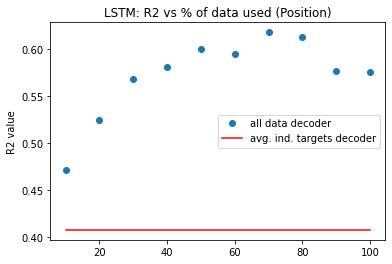

In [7]:
x = [100, 90, 80, 70, 60, 50 ,40 ,30 ,20 ,10]
print(x)
ind = [0.408, 0.408,0.408, 0.408,0.408, 0.408,0.408, 0.408,0.408, 0.408]
plt.plot(x, R2_final[0], 'o',label='all data decoder')
plt.plot(x, ind, 'r',label='avg. ind. targets decoder')
plt.title('LSTM: R2 vs % of data used (Position)')
plt.ylabel('R2 value')
plt.legend()
plt.savefig('LSTM_SR_data_length_pos.png')

In [19]:
valid_range=[0.85,1]
valid_range = [x*part for x in valid_range]
print(valid_range)

[0.68, 0.8]


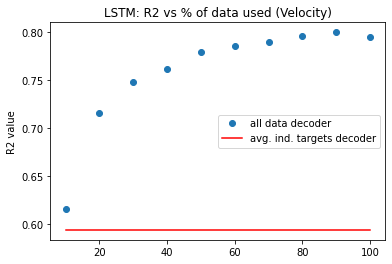

In [8]:
x = [100, 90, 80, 70, 60, 50 ,40 ,30 ,20 ,10]

ind = [0.594, 0.594,0.594, 0.594,0.594, 0.594,0.594, 0.594,0.594, 0.594]
plt.plot(x, R2_final[1], 'o',label='all data decoder')
plt.plot(x, ind, 'r',label='avg. ind. targets decoder')
plt.title('LSTM: R2 vs % of data used (Velocity)')
plt.ylabel('R2 value')
plt.legend()
plt.savefig('LSTM_SR_data_length_vel.png')